<a href="https://colab.research.google.com/github/KavindaKGD/DL_Final_Assignment/blob/main/LSTM_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!nvidia-smi

Tue Oct  7 05:13:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P0             26W /   70W |     202MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
# Basic libraries
import os, glob, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!unzip -q "/content/drive/MyDrive/street_building_dataset.zip" -d "/content/dataset"

replace /content/dataset/street_building_dataset/test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [34]:
import os
for root, dirs, files in os.walk("/content/dataset/street_building_dataset"):
    print(root, "->", len(files), "files")

/content/dataset/street_building_dataset -> 0 files
/content/dataset/street_building_dataset/test -> 0 files
/content/dataset/street_building_dataset/test/streets -> 501 files
/content/dataset/street_building_dataset/test/buildings -> 437 files
/content/dataset/street_building_dataset/train -> 0 files
/content/dataset/street_building_dataset/train/streets -> 2382 files
/content/dataset/street_building_dataset/train/buildings -> 2191 files


In [35]:
DATA_ROOT = "/content/dataset/street_building_dataset"

In [36]:
IMG_H, IMG_W = 150, 150
BATCH_SIZE = 32

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/train",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/test",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4573 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Classes: ['buildings', 'streets']


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

def rgb_to_seq(images, labels):
    images = tf.image.rgb_to_grayscale(images)
    images = tf.cast(images, tf.float32) / 255.0
    images = tf.squeeze(images, axis=-1)  # (batch, H, W)
    return images, labels

train_ds = train_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [39]:
from tensorflow.keras import layers, models, Input

timesteps = IMG_H
features = IMG_W

inputs = Input(shape=(timesteps, features))
x = layers.LSTM(128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       142,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,169 (590.50 KB)

 Trainable params: 151,169 (590.50 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_lstm.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5439 - loss: 0.6998

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5439 - loss: 0.6998 - val_accuracy: 0.5810 - val_loss: 0.6771
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5721 - loss: 0.6803 - val_accuracy: 0.5757 - val_loss: 0.6731
Epoch 3/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5664 - loss: 0.6815

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5664 - loss: 0.6815 - val_accuracy: 0.5821 - val_loss: 0.6696
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5832 - loss: 0.6733 - val_accuracy: 0.5650 - val_loss: 0.6850
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5548 - loss: 0.6835 - val_accuracy: 0.5736 - val_loss: 0.6816
Epoch 6/20
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5509 - loss: 0.6861

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5512 - loss: 0.6860 - val_accuracy: 0.5906 - val_loss: 0.6629
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5262 - loss: 0.7146 - val_accuracy: 0.5640 - val_loss: 0.6879
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5528 - loss: 0.6887 - val_accuracy: 0.5832 - val_loss: 0.6786
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5514 - loss: 0.6854 - val_accuracy: 0.5746 - val_loss: 0.6827


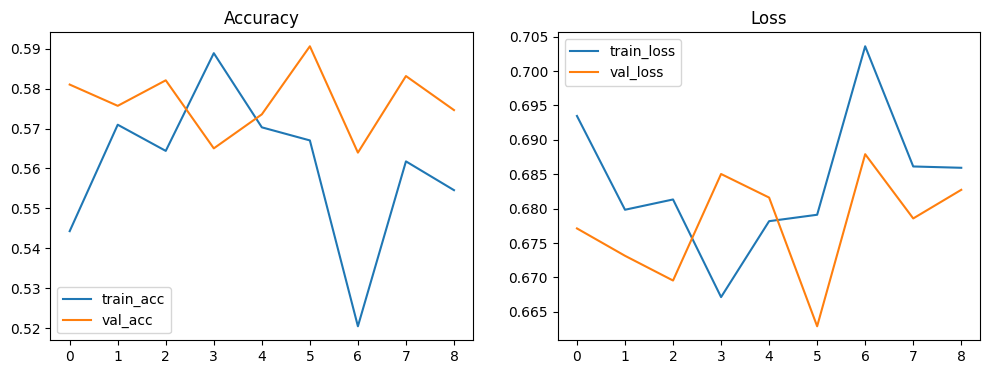

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.show()

In [42]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3889 - loss: 0.7588
Test Accuracy: 0.591


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

   buildings       0.64      0.28      0.39       437
     streets       0.58      0.86      0.69       501

    accuracy                           0.59       938
   macro avg       0.61      0.57      0.54       938
weighted avg       0.61      0.59      0.55       938



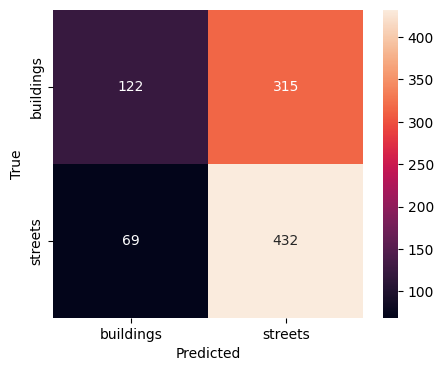

In [43]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [44]:
model.save("/content/drive/MyDrive/best_lstm_street_building.keras")